In [3]:
packageVersion("Seurat")

[1] ‘3.0.0’

### Load the matrix and sample information

In [5]:
# load the combined matrix
d.total <- readRDS("input/combined.dropseq.mat.rds")

In [3]:
library("Seurat")
library("Matrix")

In [7]:
dropseq <- CreateSeuratObject(counts = d.total, project = "dropseq", min.cells = 10)
dropseq[["percent.mt"]] <- PercentageFeatureSet(dropseq, pattern = "^mt-")
dropseq <- subset(dropseq, subset = nFeature_RNA > 100 & nCount_RNA > 300  & nFeature_RNA < 4000 & percent.mt < 10)
head(dropseq@meta.data)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
0324female-pituitary_TGCTATAGGTAA,0324female-pituitary,4929,2345,0.2434571
0324female-pituitary_AATTTCGTCGTC,0324female-pituitary,6484,2510,0.2467613
0324female-pituitary_TGACCACCGGCA,0324female-pituitary,6615,2095,2.3582766
0324female-pituitary_ATTTCAATGTTA,0324female-pituitary,5241,1906,0.4770082
0324female-pituitary_AGTTTTGTCCCC,0324female-pituitary,3845,2036,3.4070221
0324female-pituitary_TGTGTTGGGCGC,0324female-pituitary,5528,1431,4.1063676


In [8]:
table(dropseq@meta.data$orig.ident)


    0324female-pituitary       0324male-pituitary                 0511mPit 
                     968                      975                     3573 
                 control                     lac2                     lac3 
                    3648                     2665                     5253 
mPit-female-hGhrh-run1n2 
                    2785 

In [9]:
dropseq

An object of class Seurat 
27660 features across 19867 samples within 1 assay 
Active assay: RNA (27660 features)

In [10]:
dropseq@meta.data$cell <- rownames(dropseq@meta.data)

# add sex information
dropseq@meta.data$sex <- "none"
dropseq@meta.data[grep("male",dropseq@meta.data$cell),]$sex <- "male"
dropseq@meta.data[grep("female",dropseq@meta.data$cell),]$sex <- "female"

dropseq@meta.data[dropseq@meta.data$sex=="none",]$sex  <- "female"

as.character(unique(dropseq@meta.data$orig.ident))

# add the sample infromation here
dropseq@meta.data$type <- plyr::mapvalues(dropseq@meta.data$orig.ident,as.character(unique(dropseq@meta.data$orig.ident)),
                          c("WT_8wk_0324","WT_8wk_0324","WT_8wk_0511","WT_13wk_ctrl","WT_13wk_lac1","WT_13wk_lac2","transgenic_8wk"
                           ))

[1] "0324female-pituitary"     "0324male-pituitary"      
[3] "0511mPit"                 "control"                 
[5] "lac2"                     "lac3"                    
[7] "mPit-female-hGhrh-run1n2"

In [11]:
table(dropseq@meta.data$sex,dropseq@meta.data$type)

        
         WT_8wk_0324 WT_8wk_0511 WT_13wk_ctrl WT_13wk_lac1 WT_13wk_lac2
  female         968        1476         3648         2665         5253
  male           975        2097            0            0            0
        
         transgenic_8wk
  female           2785
  male                0

### Align samples using Seurat3

In [12]:
dropseq.list <- SplitObject(dropseq, split.by = "type")

In [13]:
names(dropseq.list)

[1] "WT_8wk_0324"    "WT_8wk_0511"    "WT_13wk_ctrl"   "WT_13wk_lac1"  
[5] "WT_13wk_lac2"   "transgenic_8wk"

In [14]:
for (i in 1:length(dropseq.list)) {
    dropseq.list[[i]] <- NormalizeData(dropseq.list[[i]], verbose = FALSE)
    dropseq.list[[i]] <- FindVariableFeatures(dropseq.list[[i]], selection.method = "vst", nfeatures = 2000, verbose = FALSE)
}

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -3.1247”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.30103”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  2.9775e-16”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -3.1438”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.30103”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  8.5436e-16”

In [16]:
dropseq.anchors <- FindIntegrationAnchors(object.list = dropseq.list, dims = 1:30, verbose = FALSE)

In [17]:
dropseq.integrated <- IntegrateData(anchorset = dropseq.anchors, dims = 1:30, verbose = FALSE)

In [18]:
library(ggplot2)
library(cowplot)
DefaultAssay(dropseq.integrated) <- "integrated"


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [19]:
dropseq.integrated <- ScaleData(dropseq.integrated, verbose = FALSE)

In [20]:
dropseq.integrated <- RunPCA(dropseq.integrated, npcs = 25, verbose = FALSE)

In [5]:
dropseq.integrated <- RunUMAP(dropseq.integrated, reduction = "pca", dims = 1:25)

In [7]:
dropseq.integrated <- FindNeighbors(dropseq.integrated, reduction = "pca", dims = 1:25)
dropseq.integrated <- FindClusters(dropseq.integrated, resolution = c(0.4,0.5,0.6,1))

Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 19867
Number of edges: 930645

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9080
Number of communities: 14
Elapsed time: 3 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 19867
Number of edges: 930645

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8936
Number of communities: 15
Elapsed time: 3 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 19867
Number of edges: 930645

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8812
Number of communities: 16
Elapsed time: 3 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 19867
Number of edges: 930645

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8448
Number of communities: 22
Elapsed time: 3 seconds


In [8]:
library(cowplot)
library(ggplot2)

Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [70]:
# name the clusters based on the markers (resoultion 0.4)
dropseq.integrated@meta.data$res.name <- plyr::mapvalues(dropseq.integrated@meta.data$integrated_snn_res.0.4,
        0:13,c("Lac","Som","Mel","Mult","MacPh","Sox2+","Gona","Unk","Cort","Thyr","Mki67+","FS","Rbc","NK"))

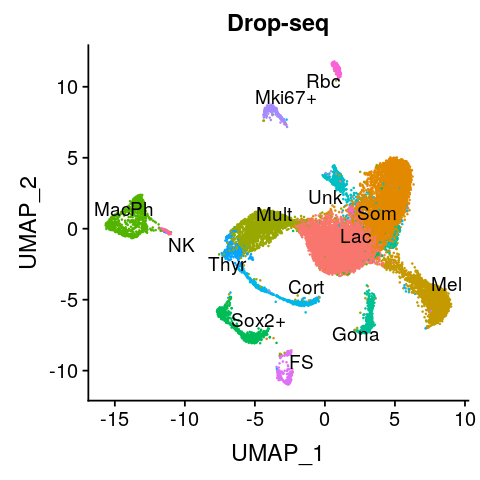

In [71]:
options(repr.plot.width=4,repr.plot.height=4)
DimPlot(dropseq.integrated, reduction = "umap", label = TRUE, repel = T,group.by = "res.name") + NoLegend() + ggtitle("Drop-seq")

In [72]:
Idents(dropseq.integrated) <- "res.name"

In [73]:
# Exclude the NK, Rbc, Thyr and Unk Cluster here
dropseq.integrated <- subset(dropseq.integrated,idents=c("Unk","NK","Thyr","Rbc"),invert=T)

In [74]:
dropseq.integrated@meta.data <- droplevels(dropseq.integrated@meta.data)

In [75]:
# assgin the cluster color here
df.col <- c('#E41A1C','#7F5477','#3A86A5','#B47229','#658E67','#91569B','#CB6651',
    '#FF8904','#E8D430','#47A265','#F781BF')
names(df.col) <- c("Som","Lac","Mult","Mki67+","Gona","Mel","Cort",
            "Sox2+","FS","MacPh")

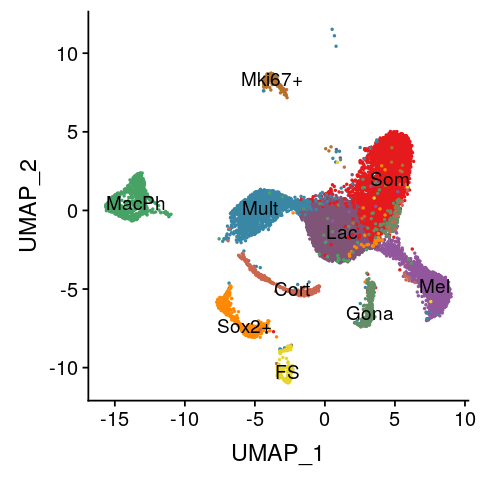

In [76]:
options(repr.plot.width=4,repr.plot.height=4)
DimPlot(dropseq.integrated , reduction = "umap", label = TRUE, repel = F,pt.size = .3) + NoLegend() + 
 scale_color_manual(values=df.col[Idents(dropseq.integrated)])

In [77]:
table(dropseq.integrated@meta.data$type)


transgenic_8wk   WT_13wk_ctrl   WT_13wk_lac1   WT_13wk_lac2    WT_8wk_0324 
          2596           3532           2557           5057           1667 
   WT_8wk_0511 
          2996 

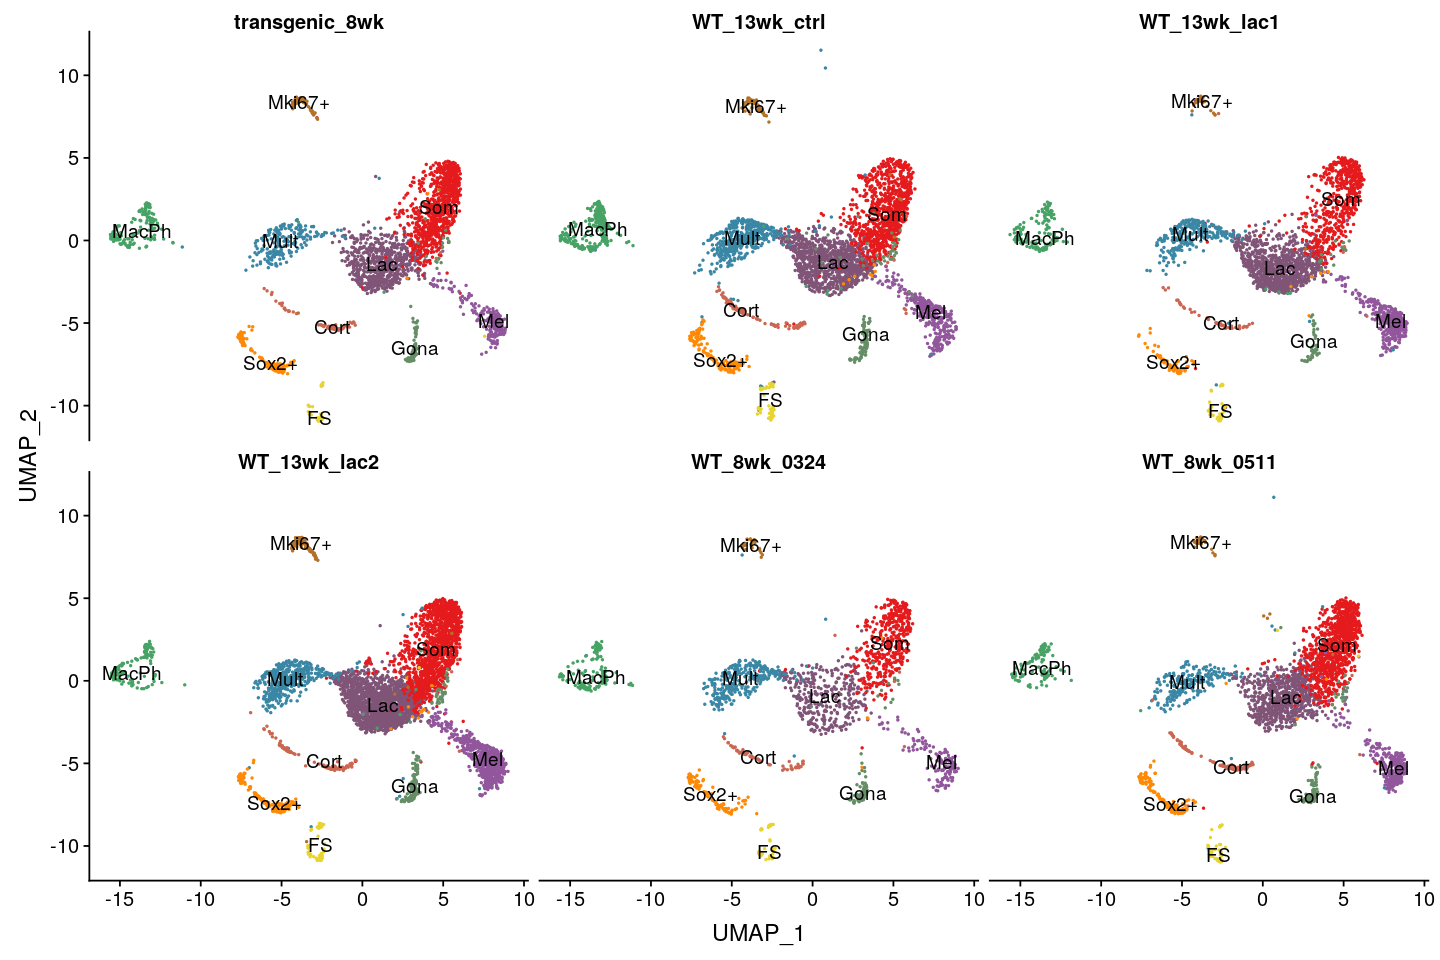

In [78]:
options(repr.plot.width=12,repr.plot.height=8)
DimPlot(dropseq.integrated , reduction = "umap", label = TRUE, repel = F,pt.size = .3,split.by="type") + NoLegend() + 
 scale_color_manual(values=df.col[Idents(dropseq.integrated)])

#### Output the detail number of each experiment here

In [79]:
table(dropseq.integrated@meta.data$type,dropseq.integrated@meta.data$res.name,dropseq.integrated@meta.data$sex)

, ,  = female

                
                  Lac  Som  Mel Mult MacPh Sox2+ Gona Cort Mki67+   FS
  transgenic_8wk  700  915  194  209   160   119   88   79     89   43
  WT_13wk_ctrl   1035  924  340  469   259   160  130  106     53   56
  WT_13wk_lac1    978  569  364  250   159    71   55   50     24   37
  WT_13wk_lac2   1772 1323  691  486   133   170  151  104    149   78
  WT_8wk_0324     251  197   62  193    65    51   22   31     11   15
  WT_8wk_0511     413  266  140   98    50    56   47   47     11   26

, ,  = male

                
                  Lac  Som  Mel Mult MacPh Sox2+ Gona Cort Mki67+   FS
  transgenic_8wk    0    0    0    0     0     0    0    0      0    0
  WT_13wk_ctrl      0    0    0    0     0     0    0    0      0    0
  WT_13wk_lac1      0    0    0    0     0     0    0    0      0    0
  WT_13wk_lac2      0    0    0    0     0     0    0    0      0    0
  WT_8wk_0324      94  228   84  107    82    50   55   36     12   21
  WT_8wk_0511 

### DotPlot of markers here

In [80]:
genes.plot <- c("Pou1f1","Prl","Gh","Ghrhr","Tshb","Top2a","Mki67","Fshb","Lhb","Gnrhr","Pomc","Pax7","Tbx19","Crhr1",
                 "Sox2","Vim","Fstl1","Col1a1","Ctss")

DefaultAssay(dropseq.integrated) <- "RNA"
dropseq.integrated <- NormalizeData(dropseq.integrated)
dropseq.integrated <- ScaleData(dropseq.integrated)

unique(Idents(dropseq.integrated))

Centering and scaling data matrix


[1] Lac    Som    Mel    Mult   MacPh  Sox2+  Gona   Cort   Mki67+ FS    
Levels: Lac Som Mel Mult MacPh Sox2+ Gona Cort Mki67+ FS

In [82]:
cluster.order <- c("Lac","Som","Mult","Mki67+","Gona","Mel","Cort","Sox2+","FS","MacPh")

dropseq.integrated@meta.data$res.name <- factor(dropseq.integrated@meta.data$res.name,levels=rev(cluster.order))

Idents(dropseq.integrated) <- "res.name"

In [85]:
table(dropseq.integrated@meta.data$type)


transgenic_8wk   WT_13wk_ctrl   WT_13wk_lac1   WT_13wk_lac2    WT_8wk_0324 
          2596           3532           2557           5057           1667 
   WT_8wk_0511 
          2996 

In [86]:
## take out wt cells for plot here
dropseq.integrated.wt <- subset(dropseq.integrated,subset = type %in% c("WT_13wk_ctrl","WT_13wk_lac1","WT_13wk_lac2",
                                                                          "WT_8wk_0324","WT_8wk_0511"))

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.


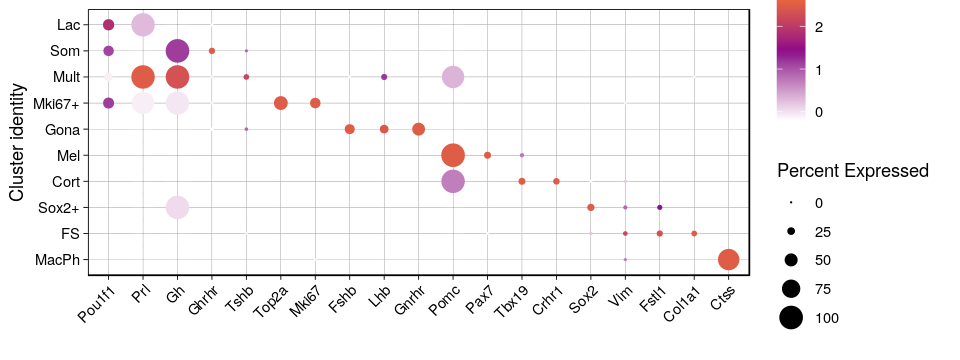

In [90]:
options(repr.plot.height=3,repr.plot.width=8)
DotPlot(dropseq.integrated.wt, features = rev(genes.plot)) + RotatedAxis() + #coord_flip()+  
  scale_colour_gradientn(
      limits = c(-0.2,3), # here set -0.2 as a cutoff for visulization
  colours=c("white", "darkmagenta", "darkorange1"),na.value="#FFFFFF1a") +  ## values less than 0.001 will be transparent white (to reduce noise)
   theme_linedraw() + theme(axis.text.x = element_text(angle=45,hjust=1)) + xlab("") + ylab("Cluster identity")